In [1]:
# 必要なライブラリの読み込み
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# データセットのダウンロード
# 2回目以降は実行する必要はありません
from urllib import request

# trainデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/train.pickle'
request.urlretrieve(url, 'train.pickle')

# testデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/test.pickle'
request.urlretrieve(url, 'test.pickle')

# ラベルデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/label.pickle'
request.urlretrieve(url, 'label.pickle')

('label.pickle', <http.client.HTTPMessage at 0x104d2f198>)

In [3]:
# pickleのサンプルプログラム
import pickle

# 適当なオブジェクトを用意
obj = '保存されるオブジェクトです'

# Pythonオブジェクトをpickleファイルとして保存
with open('sample.pickle','wb') as f:
    pickle.dump(obj, f) # (Pythonオブジェクト, pickleファイル)

# pickleファイルをPythonオブジェクトとして読込
with open('sample.pickle','rb') as f:
    loaded_obj = pickle.load(f)  # (pickleファイル)

# 読み込んだオブジェクトを確認
print(loaded_obj)

保存されるオブジェクトです


In [4]:
# pickle形式のファイルを読み込む関数
# (保存されたpickleファイル)
def unpickle(file):
    # 保存されたpickleファイルを読み込み
    # 'rb'は｢読み込み専用(r)｣かつ｢バイト列(b)｣を意味する
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

In [5]:
# データの読み込みを実行
train = unpickle('train.pickle')
test = unpickle('test.pickle')
label = unpickle('label.pickle')

In [6]:
# trainデータの型を確認
print(type(train))
print(type(test))
print(type(label))

<class 'dict'>
<class 'dict'>
<class 'list'>


In [13]:
# クラスラベルを確認
label

['clock', 'cup', 'bicycle', 'television', 'chair']

In [20]:
#データを変数に格納
X_train = train['data']
y_train = train['label']
X_test = test['data']
y_test = test['label']

In [21]:
# サンプル数を確認
N_train = len(X_train)  
N_test = len(X_test)
print(N_train, N_test)


2500 500


In [22]:
# 画像サイズを確認
# 3チャンネル × 縦32ピクセル × 横32ピクセル
print(train['data'].shape)
print(test['data'].shape)

(2500, 3, 32, 32)
(500, 3, 32, 32)


In [24]:
# 正規化処理
X_train/=255.0
X_test/=255.0

In [25]:
# testデータのサンプルについて情報を確認する関数
# (testデータのindex)
def show_test_sample_info(index):
    # (channel, height, width)を(height, width, channel)に変換
    img = X_test[index].transpose(1,2,0)
    
    # 画像を出力
    plt.imshow(img)
    plt.show()
    
    # 正解ラベルを出力
    print('class: ' + label[y_test[index]])
    print('label: ' + str(y_test[index]))

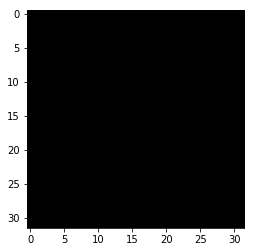

class: bicycle
label: 2


In [29]:
# testデータのサンプルについて情報を確認
# 引数のindexを変えていろいろな画像を出力してみましょう
show_test_sample_info(290)

In [30]:
# 必要なライブラリの読み込み
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

In [31]:
# CNNの定義
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 5) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [32]:
# 必要なライブラリを読み込み
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

In [33]:
# 分類器インスタンスの生成
model = L.Classifier(CNN())

# optimizerの生成
optimizer = chainer.optimizers.SGD() # 今回はSGDを採用
optimizer.setup(model)               # モデルの構造を読み込ませる

# ミニバッチに含まれるサンプル数を指定
batchsize = 100

# epoch数を指定
n_epoch = 100

In [34]:
# trainerを定義
train = tuple_dataset.TupleDataset(X_train,y_train)
train_iter = iterators.SerialIterator(train,batch_size=batchsize,shuffle=True)
updater = training.StandardUpdater(train_iter,optimizer)
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [35]:
# Extensionsを利用してtrainerの機能を拡張
test = tuple_dataset.TupleDataset(X_test,y_test)
test_iter = iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [36]:
# 学習を実行
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.1924         1.60948     0.282                     1.60932               
2           0.2228         1.60934     0.298                     1.60919               
3           0.2572         1.60923     0.344                     1.60911               
4           0.2652         1.60913     0.28                      1.60905               
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
       100 iter, 4 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
5           0.262          1.60912     0.28                      1.60901               
6           0.2448         1.60908     0.342                     1.60896               
7           0.2772         1.60903     0.362                     1.60892               
8           0.2836         1.609       0.344                 

55          0.2764         1.60827     0.358                     1.60815               
56          0.274          1.60825     0.338                     1.60816               
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
      1400 iter, 56 epoch / 100 epochs
   0.30759 iters/sec. Estimated time to finish: 0:59:36.139990.
57          0.3132         1.60824     0.338                     1.60811               
58          0.294          1.60818     0.276                     1.60812               
59          0.2944         1.60817     0.282                     1.60808               
60          0.3212         1.60817     0.29                      1.60805               
     total [##############################....................] 60.00%
this epoch [..................................................]  0.00%
      1500 iter, 60 epoch / 100 epochs
   0.30886 iters/sec. Estimated time to finish